# 1. Setup

## 1.1 Install Dependencies

In [1]:
!pip install tensorflow==2.4.1 tensorflow-gpu==2.4.1 opencv-python matplotlib

ERROR: Could not find a version that satisfies the requirement tensorflow==2.4.1 (from versions: 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.11.1, 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.12.1, 2.13.0rc0, 2.13.0rc1, 2.13.0rc2, 2.13.0, 2.13.1, 2.14.0rc0, 2.14.0rc1, 2.14.0, 2.14.1, 2.15.0rc0, 2.15.0rc1, 2.15.0, 2.15.1, 2.16.0rc0, 2.16.1, 2.16.2, 2.17.0rc0, 2.17.0rc1, 2.17.0, 2.17.1, 2.18.0rc0, 2.18.0rc1, 2.18.0rc2, 2.18.0)
ERROR: No matching distribution found for tensorflow==2.4.1


## 1.2 Import Dependencies

In [289]:
# Import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt
# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

## 1.3 Set GPU Growth

In [4]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

## 1.4 Create Folder Structures

In [5]:
# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')


# Make the directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

# 2. Collect Positives and Anchors

## 2.1 Untar Labelled Faces in the Wild Dataset

In [7]:
# http://vis-www.cs.umass.edu/lfw/

In [147]:
# Move LFW Images to the following repository data/negative
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

In [148]:
os.listdir('lfw')

['Aaron_Eckhart',
 'Aaron_Guiel',
 'Aaron_Patterson',
 'Aaron_Peirsol',
 'Aaron_Pena',
 'Aaron_Sorkin',
 'Aaron_Tippin',
 'Abbas_Kiarostami',
 'Abba_Eban',
 'Abdel_Aziz_Al-Hakim',
 'Abdel_Madi_Shabneh',
 'Abdel_Nasser_Assidi',
 'Abdoulaye_Wade',
 'Abdulaziz_Kamilov',
 'Abdullah',
 'Abdullah_Ahmad_Badawi',
 'Abdullah_al-Attiyah',
 'Abdullah_Gul',
 'Abdullah_Nasseef',
 'Abdullatif_Sener',
 'Abdul_Majeed_Shobokshi',
 'Abdul_Rahman',
 'Abel_Aguilar',
 'Abel_Pacheco',
 'Abid_Hamid_Mahmud_Al-Tikriti',
 'Abner_Martinez',
 'Abraham_Foxman',
 'Aby_Har-Even',
 'Adam_Ant',
 'Adam_Freier',
 'Adam_Herbert',
 'Adam_Kennedy',
 'Adam_Mair',
 'Adam_Rich',
 'Adam_Sandler',
 'Adam_Scott',
 'Adelina_Avila',
 'Adel_Al-Jubeir',
 'Adisai_Bodharamik',
 'Adolfo_Aguilar_Zinser',
 'Adolfo_Rodriguez_Saa',
 'Adoor_Gopalakarishnan',
 'Adriana_Lima',
 'Adriana_Perez_Navarro',
 'Adrianna_Zuzic',
 'Adrian_Annus',
 'Adrian_Fernandez',
 'Adrian_McPherson',
 'Adrian_Murrell',
 'Adrian_Nastase',
 'Adrien_Brody',
 'Afton_S

## 2.2 Collect Positive and Anchor Classes

In [149]:
# Import uuid library to generate unique image names
import uuid
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))


# Establish a connection to the webcam
 # Cut down frame to 250x250px

cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    ret, frame = cap.read()
   
    # Cut down frame to 250x250px
    frame = frame[120:120+250,200:200+250, :]
    
    # Collect anchors 
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path 
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
    
    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path 
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)
    
    # Show image back to screen
    cv2.imshow('Image Collection', frame)
    
    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

# 2.x NEW - Data Augmentation

In [153]:
def data_aug(img):
    data = []
    # Convert NumPy array to TensorFlow tensor
    img = tf.convert_to_tensor(img, dtype=tf.float32)
    # Normalize pixel values to [0, 1] range if necessary
    img = img / 255.0

    for i in range(9):
        augmented_img = img
        augmented_img = tf.image.stateless_random_brightness(augmented_img, max_delta=0.02, seed=(i, i + 1))
        augmented_img = tf.image.stateless_random_contrast(augmented_img, lower=0.6, upper=1.0, seed=(i, i + 2))
        augmented_img = tf.image.stateless_random_flip_left_right(augmented_img, seed=(i, i + 3))
        augmented_img = tf.image.stateless_random_jpeg_quality(
            augmented_img, min_jpeg_quality=90, max_jpeg_quality=100, seed=(i, i + 4)
        )
        augmented_img = tf.image.stateless_random_saturation(augmented_img, lower=0.9, upper=1.0, seed=(i, i + 5))
        # Add the augmented image to the list
        data.append(augmented_img)

    return data




In [154]:
import os
import uuid
import cv2
import tensorflow as tf

# Ensure the image is loaded correctly
img_path = os.path.join(ANC_PATH, r'D:\Sucess-2\data\anchor\f69ed4e5-bade-11ef-aaa5-5cfb3aac15a4.jpg')

# Print to verify the image path
print(f"ANC_PATH: {ANC_PATH}")
print(f"Loading image from: {img_path}")

# Check if the image exists at the given path
if not os.path.exists(img_path):
    raise FileNotFoundError(f"Image at path {img_path} could not be found. Please check the path.")

# Read the image
img = cv2.imread(img_path)

# Check if the image was loaded properly
if img is None:
    raise FileNotFoundError(f"Image at path {img_path} could not be loaded. Please check the path.")

# Apply data augmentation
augmented_images = data_aug(img)

# Save augmented images
for image in augmented_images:
    image_np = (image.numpy() * 255).astype("uint8")
    cv2.imwrite(os.path.join(ANC_PATH, f'{uuid.uuid1()}.jpg'), cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR))

# Iterate through positive images
for file_name in os.listdir(POS_PATH):
    if file_name.lower().endswith('.jpg'):  # Ensure only JPG files are processed
        img_path = os.path.join(POS_PATH, file_name)
        
        img = cv2.imread(img_path)
        
        if img is None:
            print(f"Failed to load image: {img_path}")
            continue
        
        augmented_images = data_aug(img)
        for image in augmented_images:
            image_np = (image.numpy() * 255).astype("uint8")
            cv2.imwrite(os.path.join(POS_PATH, f'{uuid.uuid1()}.jpg'), cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR))


ANC_PATH: e8dddef6-bade-11ef-a7c4-5cfb3aac15a4.jpg'
Loading image from: D:\Sucess-2\data\anchor\f69ed4e5-bade-11ef-aaa5-5cfb3aac15a4.jpg


# 3. Load and Preprocess Images

## 3.1 Get Image Directories

In [290]:
ANC_PATH = r"data/anchor"
POS_PATH = r"data/positive"
NEG_PATH = r"data/negative"

anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(3000)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(3000)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(3000)



dir_test = anchor.as_numpy_iterator()
print(dir_test.next())


b'data\\anchor\\75948a77-bb08-11ef-bd11-5cfb3aac15a4.jpg'


## 3.2 Preprocessing - Scale and Resize

In [291]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0

    # Return image
    return img

img = preprocess(r'data\anchor\589a9aa1-bae7-11ef-b378-5cfb3aac15a4.jpg')
img.numpy().max()

0.87034315

## 3.3 Create Labelled Dataset

In [292]:
# (anchor, positive) => 1,1,1,1,1
# (anchor, negative) => 0,0,0,0,0

In [293]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)
samples = data.as_numpy_iterator()
exampple = samples.next()
exampple

(b'data\\anchor\\f6d0638d-bade-11ef-a5b3-5cfb3aac15a4.jpg',
 b'data\\positive\\6d966235-bb08-11ef-8a48-5cfb3aac15a4.jpg',
 1.0)

## 3.4 Build Train and Test Partition

In [ ]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

res = preprocess_twin(*exampple)
plt.imshow(res[1])
res[2]


# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=10000)



# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)


# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# 4. Model Engineering

## 4.1 Build Embedding Layer

In [295]:
inp = Input(shape=(100,100,3), name='input_image')
c1 = Conv2D(64, (10,10), activation='relu')(inp)
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)
mod = Model(inputs=[inp], outputs=[d1], name='embedding')
mod.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 91, 91, 64)     │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 40, 40, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 17, 17, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 6, 6, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 4096)           │    37,752,832 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

In [296]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')


embedding = make_embedding()
embedding.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 91, 91, 64)     │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 40, 40, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 17, 17, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 6, 6, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 4096)           │    37,752,832 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

## 4.2 Build Distance Layer

In [297]:
# Siamese L1 Distance class
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)
    
l1 = L1Dist()
# l1(anchor_embedding, validation_embedding)

## 4.3 Make Siamese Model

In [298]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

import tensorflow as tf
from tensorflow.keras.layers import Layer

# Siamese L1 Distance class
class L1Dist(Layer):
    def __init__(self, **kwargs):
        super().__init__()
       
    def call(self, input_embedding, validation_embedding):
        # Convert to tensors
        input_embedding = tf.convert_to_tensor(input_embedding)
        validation_embedding = tf.convert_to_tensor(validation_embedding)
        
        # Check shape compatibility
        if input_embedding.shape != validation_embedding.shape:
            raise ValueError(f"Shape mismatch: {input_embedding.shape} vs {validation_embedding.shape}")
        
        # Calculate L1 distance
        return tf.math.abs(input_embedding - validation_embedding)

# Example embeddings
inp_embedding = tf.random.normal((1, 4096))  # Simulated anchor embedding
val_embedding = tf.random.normal((1, 4096))  # Simulated validation embedding

# Create and test the L1Dist layer
siamese_layer = L1Dist()
distances = siamese_layer(inp_embedding, val_embedding)

print("Distances:", distances.numpy())


Distances: [[0.2670877  3.9535258  0.19058692 ... 0.4384489  3.176177   0.626842  ]]


In [299]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

# Input layers for the two images
input_image = Input(shape=(100, 100, 3), name="input_image")
validation_image = Input(shape=(100, 100, 3), name="validation_image")

# Shared embedding network
shared_network = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(4096, activation=None)  # Final embedding
], name="shared_embedding_network")

# Create embeddings for the two inputs
inp_embedding = shared_network(input_image)
val_embedding = shared_network(validation_image)

# Compute L1 distance
siamese_layer = L1Dist()
distances = siamese_layer(inp_embedding, val_embedding)

# Add a classifier on top of the distances
classifier = Dense(1, activation='sigmoid', name="output_layer")(distances)

# Define the Siamese network
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name="SiameseNetwork")


siamese_layer = L1Dist()
distances = siamese_layer(inp_embedding, val_embedding)
classifier = Dense(1, activation='sigmoid')(distances)
classifier
# siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')
siamese_network.summary()


Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_image         │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_image    │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ shared_embedding_n… │ (None, 4096)      │  4,114,624 │ input_image[0][0… │
│ (Sequential)        │                   │            │ validation_image… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist_12 (L1Dist) │ (None, 4096)      │          0 │ shared_embedding… │
│                     │                   │            │ shared_embedding… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_layer        │ (None, 1)         │      4,097 │ l1_dist_12[0][0]  │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,118,721 (15.71 MB)

 Trainable params: 4,118,721 (15.71 MB)

 Non-trainable params: 0 (0.00 B)

In [300]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

siamese_model = make_siamese_model()
siamese_model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist_14 (L1Dist) │ (1, None, 4096)   │          0 │ embedding[2][0],  │
│                     │                   │            │ embedding[3][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (1, None, 1)      │      4,097 │ l1_dist_14[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

# 5. Training

## 5.1 Setup Loss and Optimizer

In [301]:
binary_cross_loss = tf.losses.BinaryCrossentropy()
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

## 5.2 Establish Checkpoints

In [302]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

## 5.3 Build Train Step Function

In [303]:
test_batch = train_data.as_numpy_iterator()
batch_1 = test_batch.next()
X = batch_1[:2]
y = batch_1[2]
y

array([1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 1., 1., 0., 1.],
      dtype=float32)

In [304]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    # Return loss
    return loss

## 5.4 Build Training Loop

In [305]:
import os
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.losses import BinaryCrossentropy

# Define loss function and optimizer
loss_fn = BinaryCrossentropy()
optimizer = Adam(learning_rate=0.001)

# Checkpoint setup
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer, model=siamese_network)

# Define a train_step function
@tf.function
def train_step(batch):
    with tf.GradientTape() as tape:
        X, Y_true = batch[:2], batch[2]
        y_pred = siamese_network(X, training=True)
        loss = loss_fn(Y_true, y_pred)
    gradients = tape.gradient(loss, siamese_network.trainable_variables)
    optimizer.apply_gradients(zip(gradients, siamese_network.trainable_variables))
    return loss

# Training loop
def train(data, EPOCHS):
    for epoch in range(1, EPOCHS + 1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Initialize metrics
        r = Recall()
        p = Precision()
        
        for idx, batch in enumerate(data):
            # Perform a training step
            loss = train_step(batch)
            
            # Make predictions and update metrics
            yhat = siamese_network.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat)
            
            # Update progress bar
            progbar.update(idx + 1)
        
        # Print loss, precision, and recall for the epoch
        print(f"Loss: {loss.numpy()}, Recall: {r.result().numpy()}, Precision: {p.result().numpy()}")
        
        # Save checkpoints every 10 epochs
        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

# Train the model
EPOCHS = 50
train(train_data, EPOCHS)



 Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 17s 296ms/step
Loss: 0.2866847515106201, Recall: 0.6969696879386902, Precision: 0.9387755393981934

 Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step
Loss: 0.27969685196876526, Recall: 0.9275362491607666, Precision: 0.9846153855323792

 Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

# 6. Evaluate Model

## 6.1 Import Metrics

In [306]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

## 6.2 Make Predictions

In [307]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

# Get predictions
y_hat = siamese_model.predict([test_input, test_val])

# Post-process predictions: Convert probabilities to binary class labels
y_pred = [1 if pred > 0.5 else 0 for pred in y_hat.ravel()]  # Use `.ravel()` to flatten the predictions

# Ground truth
print("True Labels:", y_true)
print("Predicted Labels:", y_pred)


d:\Programme download\Python 3.10.0\lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_image']
Received: inputs=Tensor(shape=(16, 100, 100, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
True Labels: [1. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1. 0. 1. 1. 1. 1.]
Predicted Labels: [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1]


## 6.3 Calculate Metrics

In [308]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()


r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat) 

print(r.result().numpy(), p.result().numpy())

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 683ms/step


d:\Programme download\Python 3.10.0\lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_image']
Received: inputs=Tensor(shape=(None, 100, 100, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 745ms/step
0.96875 0.56363636


## 6.4 Viz Results

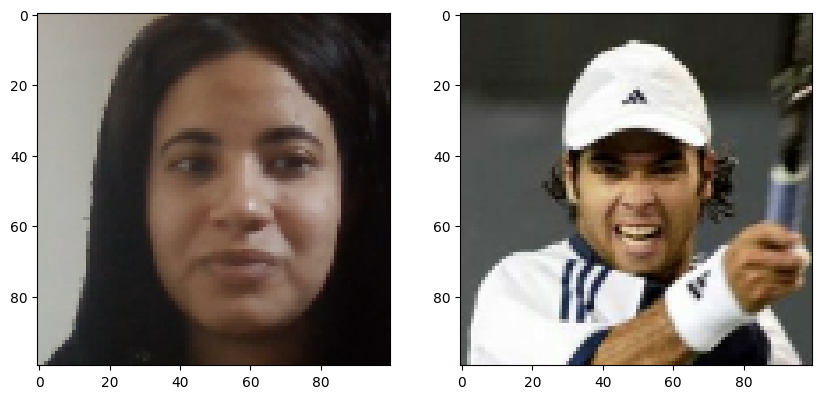

In [309]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[0])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[0])

# Renders cleanly
plt.show()

# 7. Save Model

In [310]:
# Save weights
siamese_model.save('siamesemodelv2.h5')
L1Dist
# Reload model 
siamese_model = tf.keras.models.load_model('siamesemodelv2.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

# Make predictions with reloaded model
siamese_model.predict([test_input, test_val])
# View model summary
siamese_model.summary()

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist_15 (L1Dist) │ (1, None, 4096)   │          0 │ embedding[0][0],  │
│                     │                   │            │ embedding[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (1, None, 1)      │      4,097 │ l1_dist_15[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

# 8. Real Time Test

## 8.1 Verification Function

In [311]:
import os

# Define paths
verification_images_path = os.path.join('application_data', 'verification_images')
input_image_path = os.path.join('application_data', 'input_image', 'input_image.jpg')

# Check if directories and files exist
if not os.path.exists(verification_images_path):
    print(f"Directory '{verification_images_path}' does not exist. Please check the path.")
else:
    # List files in verification_images_path
    print("Files in verification_images_path:", os.listdir(verification_images_path))
    
    # Iterate through files in the directory
    for image in os.listdir(verification_images_path):
        validation_img = os.path.join(verification_images_path, image)
        print(validation_img)

# Check if the input image exists
if not os.path.exists(input_image_path):
    print(f"File '{input_image_path}' does not exist. Please check the path.")
else:
    print(f"Input image path: {input_image_path}")


Files in verification_images_path: ['6a194cf6-bb08-11ef-89ef-5cfb3aac15a4.jpg', '6a1e00d5-bb08-11ef-9e88-5cfb3aac15a4.jpg', '6a22c34d-bb08-11ef-b8ca-5cfb3aac15a4.jpg', '6a331fb2-bb08-11ef-973e-5cfb3aac15a4.jpg', '6a37e014-bb08-11ef-9f9a-5cfb3aac15a4.jpg', '6a3c9834-bb08-11ef-997e-5cfb3aac15a4.jpg', '6a64e0d1-bb08-11ef-a598-5cfb3aac15a4.jpg', '6a732db8-bb08-11ef-a797-5cfb3aac15a4.jpg', '6a81902b-bb08-11ef-adc8-5cfb3aac15a4.jpg', '6a862a64-bb08-11ef-a4ff-5cfb3aac15a4.jpg', '6a91e804-bb08-11ef-ad0f-5cfb3aac15a4.jpg', '6ab501e7-bb08-11ef-9913-5cfb3aac15a4.jpg', '6ab9d32c-bb08-11ef-9db3-5cfb3aac15a4.jpg', '6abe7a5e-bb08-11ef-8ecb-5cfb3aac15a4.jpg', '6ac339dd-bb08-11ef-8ad7-5cfb3aac15a4.jpg', '6ac7d938-bb08-11ef-872d-5cfb3aac15a4.jpg', '6ad652ed-bb08-11ef-80b0-5cfb3aac15a4.jpg', '6adb253d-bb08-11ef-b278-5cfb3aac15a4.jpg', '6ae0083a-bb08-11ef-820d-5cfb3aac15a4.jpg', '6ae72d3c-bb08-11ef-9276-5cfb3aac15a4.jpg', '6aebcd69-bb08-11ef-a0c0-5cfb3aac15a4.jpg', '6af0985b-bb08-11ef-81fb-5cfb3aac15a4.jp

In [312]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

## 8.2 OpenCV Real Time Verification

In [313]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder 
#         hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
#         h, s, v = cv2.split(hsv)

#         lim = 255 - 10
#         v[v > lim] = 255
#         v[v <= lim] -= 10
        
#         final_hsv = cv2.merge((h, s, v))
#         img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)

        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(siamese_model, 0.5, 0.5)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━

In [314]:
np.sum(np.squeeze(results) > 0.9)
results

[array([[[0.50073355]]], dtype=float32),
 array([[[0.5007644]]], dtype=float32),
 array([[[0.5009579]]], dtype=float32),
 array([[[0.5007025]]], dtype=float32),
 array([[[0.50068504]]], dtype=float32),
 array([[[0.50069565]]], dtype=float32),
 array([[[0.50067675]]], dtype=float32),
 array([[[0.5007723]]], dtype=float32),
 array([[[0.5006764]]], dtype=float32),
 array([[[0.5004109]]], dtype=float32),
 array([[[0.50057644]]], dtype=float32),
 array([[[0.5008005]]], dtype=float32),
 array([[[0.50094354]]], dtype=float32),
 array([[[0.5007897]]], dtype=float32),
 array([[[0.50063556]]], dtype=float32),
 array([[[0.50063556]]], dtype=float32),
 array([[[0.5007383]]], dtype=float32),
 array([[[0.50068384]]], dtype=float32),
 array([[[0.50080997]]], dtype=float32),
 array([[[0.5007711]]], dtype=float32),
 array([[[0.50066364]]], dtype=float32),
 array([[[0.50062263]]], dtype=float32),
 array([[[0.50059706]]], dtype=float32),
 array([[[0.5005367]]], dtype=float32),
 array([[[0.5003711]]], dty